Based on https://github.com/google-research/self-organising-systems/blob/master/notebooks/texture_nca_pytorch.ipynb


In [1]:
import os
import io
import PIL.Image, PIL.ImageDraw, PIL.ImageFont
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
# !pip install -q --progress-bar off einops
from einops import rearrange
# !pip install -q --progress-bar off pykeops[colab] geomloss
from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision.models as models
from functools import partial

import torchvision

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    # wikimedia requires a user agent
    headers = {
      "User-Agent": "Requests in Colab/0.0 (https://colab.research.google.com/; no-reply@google.com) requests/0.0"
    }
    r = requests.get(url, headers=headers)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img.thumbnail((max_size, max_size), PIL.Image.NEAREST)
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))

def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))

class LoopWriter(VideoWriter):
  def __init__(self, *a, fade_len=1.0, **kw):
    super().__init__(*a, **kw)
    self._intro = []
    self._outro = []
    self.fade_len = int(fade_len*self.params['fps'])

  def add(self, img):
    if len(self._intro) < self.fade_len:
      self._intro.append(img)
      return
    self._outro.append(img)
    if len(self._outro) > self.fade_len:
      super().add(self._outro.pop(0))

  def close(self):
    for t in np.linspace(0, 1, len(self._intro)):
      img = self._intro.pop(0)*t + self._outro.pop(0)*(1.0-t)
      super().add(img)
    super().close()


torch.set_default_tensor_type('torch.cuda.FloatTensor')

def to_nchw(img):
  img = torch.as_tensor(img)
  if len(img.shape) == 3:
    img = img[None,...]
  return img.permute(0, 3, 1, 2)

!nvidia-smi -L

/usr/local/lib/python3.12/dist-packages/moviepy/config_defaults.py:47: SyntaxWarning: invalid escape sequence '\P'
  IMAGEMAGICK_BINARY = r"C:\Program Files\ImageMagick-6.8.8-Q16\magick.exe"
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:294: SyntaxWarning: invalid escape sequence '\d'
  lines_video = [l for l in lines if ' Video: ' in l and re.search('\d+x\d+', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:367: SyntaxWarning: invalid escape sequence '\d'
  rotation_lines = [l for l in lines if 'rotate          :' in l and re.search('\d+$', l)]
/usr/local/lib/python3.12/dist-packages/moviepy/video/io/ffmpeg_reader.py:370: SyntaxWarning: invalid escape sequence '\d'
  match = re.search('\d+$', rotation_line)
  if event.key is 'enter':

  _C._set_default_tensor_type(t)



GPU 0: Tesla T4 (UUID: GPU-69d5173d-acf4-0205-625b-0dcb7aa130d5)


In [2]:
def create_l2_losses():
  def loss_f(imgs, targets):
    sq = torch.square(targets - imgs)
    loss = sq.mean()
    return loss, sq
  return loss_f


def batched_crop(x0, cxs, cys, SSIZE):
    B, C, H, W = x0.shape
    device = x0.device

    dy, dx = torch.meshgrid(
        torch.arange(SSIZE, device=device),
        torch.arange(SSIZE, device=device),
        indexing="ij"
    )

    yy = dy[None, :, :] + cxs[:, None, None]   # [B, SSIZE, SSIZE]  height
    xx = dx[None, :, :] + cys[:, None, None]   # [B, SSIZE, SSIZE]  width

    batch_idx = torch.arange(B, device=device)[:, None, None, None]
    chan_idx  = torch.arange(C, device=device)[None, :, None, None]

    batch_idx = batch_idx.expand(B, C, SSIZE, SSIZE)
    chan_idx  = chan_idx.expand(B, C, SSIZE, SSIZE)
    yy        = yy[:, None, :, :].expand(B, C, SSIZE, SSIZE)
    xx        = xx[:, None, :, :].expand(B, C, SSIZE, SSIZE)

    out = x0[batch_idx, chan_idx, yy, xx]  # [B, C, SSIZE, SSIZE]
    return out

In [15]:
#@title Minimalistic Neural CA
ident = torch.tensor([[0.0,0.0,0.0],[0.0,1.0,0.0],[0.0,0.0,0.0]])
sobel_x = torch.tensor([[-1.0,0.0,1.0],[-2.0,0.0,2.0],[-1.0,0.0,1.0]])
lap = torch.tensor([[1.0,2.0,1.0],[2.0,-12,2.0],[1.0,2.0,1.0]])


def perchannel_conv(x, filters, padding):
  '''filters: [filter_n, h, w]'''
  b, ch, h, w = x.shape
  y = x.reshape(b*ch, 1, h, w)
  y = torch.nn.functional.pad(y, [1, 1, 1, 1], padding)
  y = torch.nn.functional.conv2d(y, filters[:,None])
  return y.reshape(b, -1, h, w)

def perception(x, padding):
  filters = torch.stack([ident, sobel_x, sobel_x.T, lap] )
  # filters = torch.stack([filters])
  return perchannel_conv(x, filters, padding)



class CA(torch.nn.Module):

  def __init__(self, chn, hidden_n):
    super().__init__()
    self.chn = chn
    self.hid = hidden_n

    self.w1 = torch.nn.Conv2d(chn*4, hidden_n, 1, groups=1)

    self.w2 = torch.nn.Conv2d(hidden_n, chn, 1, bias=False, groups=1)
    self.w2.weight.data.zero_()


  def forward(self, x, update_rate=.5, padding='constant'):

    b, c, h, w, = x.shape

    y = perception(torch.tanh(x), padding=padding)

    hidden = self.w1(y)

    y = self.w2(torch.relu(hidden))

    upd_mask = (torch.rand(b,c,h,w)+update_rate).floor()

    y = y * upd_mask

    # do not update boundary
    y[:, :, 0, :] *= 0.
    y[:, :, -1, :] *= 0.
    y[:, :, :, 0] *= 0.
    y[:, :, :, -1] *= 0.

    return x+y, y

  def seed(self, n, sz=128):
    return torch.zeros(n, self.chn, sz, sz)
    # return (torch.rand(n, self.chn, sz, sz) - .5) * .1

  def to_rgb(self, x):
    return x[...,:3,:,:]+0.5



def seed_f(n, sz=128):

  seed = torch.ones(n, CHN, sz, sz) * .1
  # seed = torch.zeros(n, CHN, sz, sz)

  gx = torch.sin(torch.linspace(0, torch.pi, steps=sz))
  gy = torch.sin(torch.linspace(0, torch.pi, steps=sz))

  GY, GX = torch.meshgrid(gy, gx)

  return seed * GX * GY


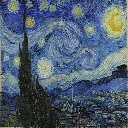

In [16]:
url = 'https://i.imgur.com/VSUuXCA.png'

TSIZE = 128  # total size, H==W
SSIZE = 64   # simulation size, H==W
BSIZE = 4    # batch size, N

with torch.no_grad():
  style_img = imread(url, max_size=TSIZE)[...,:3]
  target_img = torchvision.transforms.functional.resize(to_nchw(style_img).repeat([BSIZE, 1, 1, 1]), (TSIZE, TSIZE))
  texture_loss_f = create_l2_losses()
imshow(style_img)




In [24]:
#@title setup training
CHN=12
ca = CA(CHN, CHN*8)
print('param count:', sum(p.numel() for p in ca.parameters()))

opt = torch.optim.Adam(ca.parameters(), 1e-3)
lr_sched = torch.optim.lr_scheduler.MultiStepLR(opt, [1000, 4000], 0.3)
loss_log = []
long_loss_log = []
with torch.no_grad():
  pool = seed_f(128, sz=TSIZE)
# !rm *.pt

param count: 5856


In [25]:
# initialize patch positions

# cxs = torch.randint(0, TSIZE-SSIZE, (BSIZE,))
# cys = torch.randint(0, TSIZE-SSIZE, (BSIZE,))

# cxs = torch.tensor(TSIZE//2-SSIZE//2).repeat(4,)
# cys = torch.tensor(TSIZE//2-SSIZE//2).repeat(4,)

cxs = torch.tensor([1, 1, TSIZE-SSIZE-1, TSIZE-SSIZE-1])
cys = torch.tensor([1, TSIZE-SSIZE-1, 1, TSIZE-SSIZE-1])


with torch.no_grad():
  targets = torch.stack([target_img[i, :, cxs[i]:cxs[i]+SSIZE, cys[i]:cys[i]+SSIZE] for i in range(len(cxs))], dim=0)


In [26]:
torch.backends.cudnn.benchmark = True

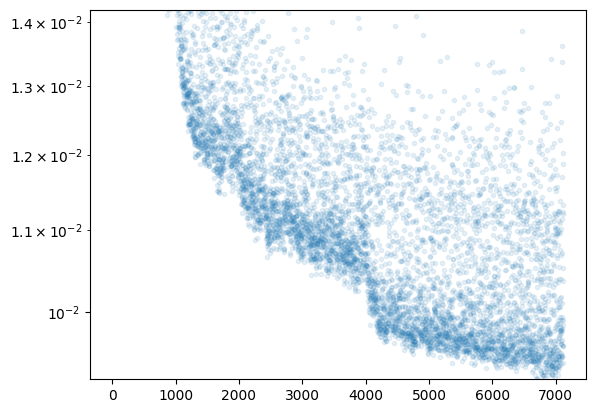

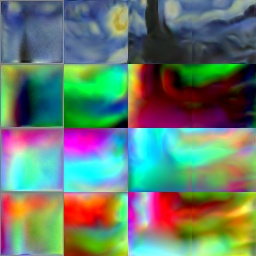

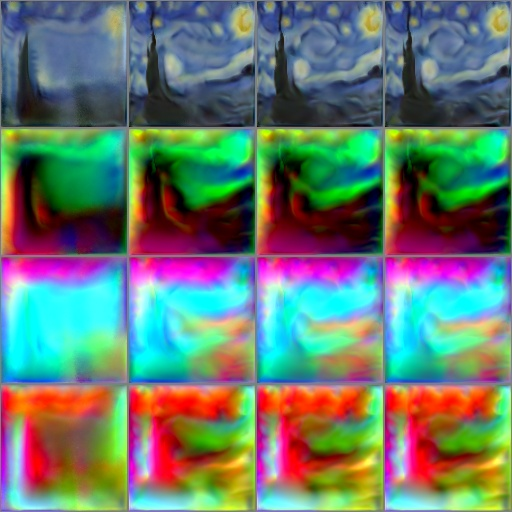

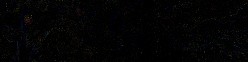

KeyboardInterrupt: 

In [33]:
#@title training loop {vertical-output: true}


def loss_f(x, targets):
  loss, sq = texture_loss_f(ca.to_rgb(x)[:, :, 1:-1, 1:-1], targets[:, :, 1:-1, 1:-1])
  reg = (x-x.clamp(-1.0, 1.0)).square().sum()
  total_loss = loss + reg
  return total_loss, loss, sq

import random


best_long_loss = np.inf
best_long_step = 0

STEP_N=50000


for i in range(STEP_N):

  batch_idx = np.random.choice(len(pool), BSIZE, replace=False)


  with torch.no_grad():
    x0 = pool[batch_idx]
    if i%8 == 0:
      x0[:1] = seed_f(1, sz=TSIZE)

    x = batched_crop(x0, cxs, cys, SSIZE)

  step_n = np.random.randint(SSIZE, SSIZE * 2)

  for _ in range(step_n):
    x, dx = ca(x)
    # x.register_hook(partial(F.normalize, dim=[1,2,3]))

  total_loss, loss, sq = loss_f(x, targets)

  total_loss.backward()

  with torch.no_grad():
    for p in ca.parameters():
      p.grad /= (p.grad.norm()+1e-8)   # normalize gradients
    opt.step()
    opt.zero_grad()
    lr_sched.step()

    for _ in range(step_n * 2):
      x0, dx0 = ca(x0)

    pool[batch_idx] = x0


    # move selection window

    # max_shift = 1

    cxs += torch.tensor(-1 + i % 3).repeat((BSIZE,))

    # cxs += torch.randint(-max_shift, max_shift+1, (BSIZE,))
    cxs = torch.clamp(cxs, 0, TSIZE-SSIZE-1)

    cys += torch.tensor(-1 + i%3).repeat((BSIZE,))
    # cys += torch.randint(-max_shift, max_shift+1, (BSIZE,))
    cys = torch.clamp(cys, 0, TSIZE-SSIZE-1)

    targets = batched_crop(target_img, cxs, cys, SSIZE)

    loss_log.append(loss.item())
    if i%64==0:
      clear_output(True)

      min_loss = np.min(loss_log)
      pl.plot(loss_log, '.', alpha=0.1)
      if min_loss > 0.0:
        pl.yscale('log')
      pl.ylim(min_loss, loss_log[len(loss_log)//5])
      pl.show()
      imgs = ca.to_rgb(x).permute([0, 2, 3, 1]).cpu()
      imgs2 = ca.to_rgb(x[:,3:,...]).permute([0, 2, 3, 1]).cpu()
      imgs3 = ca.to_rgb(x[:,6:,...]).permute([0, 2, 3, 1]).cpu()
      imgs4 = ca.to_rgb(x[:,9:,...]).permute([0, 2, 3, 1]).cpu()
      imshow(np.vstack([np.hstack(i) for i in (imgs, imgs2, imgs3, imgs4)]))

      imgs0 = ca.to_rgb(x0).permute([0, 2, 3, 1]).cpu()

      imgs01 = ca.to_rgb(x0[:,3:,...]).permute([0, 2, 3, 1]).cpu()

      imgs02 = ca.to_rgb(x0[:,6:,...]).permute([0, 2, 3, 1]).cpu()

      imgs03 = ca.to_rgb(x0[:,9:,...]).permute([0, 2, 3, 1]).cpu()
      imshow(np.vstack([np.hstack(i) for i in (imgs0, imgs01, imgs02, imgs03)]))

      sqs = sq.permute([0, 2, 3, 1]).cpu()
      imshow(np.hstack(sqs))

      pl.show()

      # show long-term behaviour
      x = seed_f(1)
      for _ in range(3000):
        x, _ = ca(x)
      img = ca.to_rgb(x)[0].permute(1, 2, 0).cpu()
      imshow(img)

      _, long_loss, _ = loss_f(x.clip(-1, 1), target_img[:1])
      long_loss_log.append(long_loss.item())


    if i%10 == 0:
      print('\rstep_n:', len(loss_log),
        # ' cuts:', (cxs, cys),
        ' loss:', loss.item(),
        ' lr:', lr_sched.get_lr()[0], end='')


In [37]:
#@title μNCA dynamics evolution video {vertical-output: true}
with torch.no_grad():

  # ca1 = torch.load('ca_%05d.pt'%best_long_step)
  ca1 = ca
with LoopWriter('final_ca.mp4', fade_len=0.5) as vid, torch.no_grad():
  x = seed_f(1, TSIZE )

  for k in tnrange(400, leave=False):
    img = ca.to_rgb(x[:,:,...])[0].permute(1, 2, 0).cpu()
    vid.add(zoom(img, 4))
    step_n = int(min(2**(k/30), 8))
    for i in range(step_n):
      x, _ = ca1(x)
vid.show()

  for k in tnrange(400, leave=False):



  0%|          | 0/400 [00:00<?, ?it/s]